In [1]:
import os
import numpy as np
import pandas as pd
import sys
from sklearn import preprocessing

import os.path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from utils.utils import create_directory

In [10]:
np.random.seed(0)

base_dir = os.path.dirname(os.path.realpath('__file__'))
archive_name = 'UCRArchive_2018'
datasets_dict = {}

In [11]:
def read_dataset(dataset_name):
    root_dir_dataset = base_dir + '/' + archive_name + '/' + dataset_name
    
    df_train = pd.read_csv(root_dir_dataset + '/' + dataset_name + '_TRAIN.tsv', sep='\t', header=None)
    
    df_test = pd.read_csv(root_dir_dataset + '/' + dataset_name + '_TEST.tsv', sep='\t', header=None)
    
    y_train = df_train.values[:, 0]
    y_test = df_test.values[:, 0]
    
    x_train = df_train.drop(columns=[0])
    x_test = df_test.drop(columns=[0])
    
    x_train.columns = range(x_train.shape[1])
    x_test.columns = range(x_test.shape[1])
    
    x_train = x_train.values
    x_test = x_test.values
    
    
    labels = np.hstack((y_train, y_test)).astype(int)
    _, labels = np.unique(labels, return_inverse=True)
    features = np.vstack((x_train, x_test))
    
    
    n_ = features.shape[0]
    shuffle_id = np.random.permutation(np.arange(n_))
    Dataset = features[shuffle_id]
    label = labels[shuffle_id]
    
    n_train = 35#int(n_*0.1)
    print(n_train)
    training_set = Dataset[:n_train]
    test_set = Dataset[n_train:]
    training_label = label[:n_train]
    test_label = label[n_train:]
    
    datasets_dict[dataset_name] = (training_set, training_label, test_set, test_label)

# 1. Wafer

In [12]:
#dataset_name = 'ItalyPowerDemand'
dataset_name = 'Wafer'

read_dataset(dataset_name)
training_set, training_label, test_set, test_label = datasets_dict[dataset_name]

35


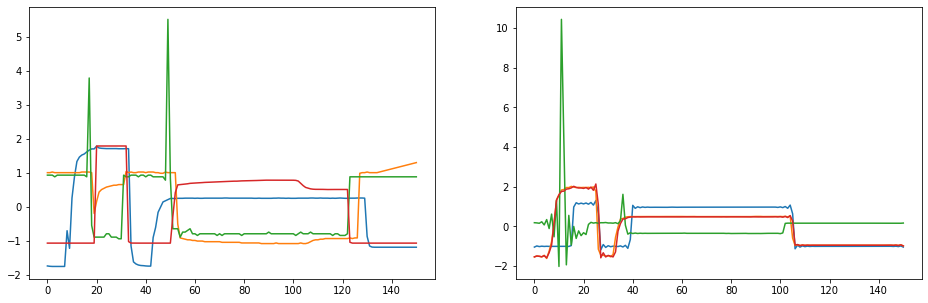

In [15]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
for i in range(4):
    plt.plot(training_set[training_label==1][i,1:])
plt.subplot(1,2,2)    
for i in range(4):
    plt.plot(training_set[training_label==0][i,1:])

In [16]:
x_train = datasets_dict[dataset_name][0]
y_train = datasets_dict[dataset_name][1]
x_test = datasets_dict[dataset_name][2]
y_test = datasets_dict[dataset_name][3]

nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))

# transform the labels from integers to one hot vectors
enc = preprocessing.OneHotEncoder(categories='auto')
enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

# save orignal y because later we will use binary
y_true = np.argmax(y_test, axis=1)

if len(x_train.shape) == 2:  # if univariate
    # add a dimension to make it multivariate with one dimension 
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

input_shape = x_train.shape[1:]

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [18]:
from utils.utils import save_logs
from utils.utils import calculate_metrics

In [19]:
batch_size = 32
nb_epochs=200
lr = 0.0005
batch_size = 32
nb_epochs = 200

mini_batch_size = int(min(x_train.shape[0]/10, batch_size))
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50,min_lr=0.00001)

## 1.0 1D-CNN

## 1.1 FCN

In [412]:
out_path =  base_dir + '/models/' + dataset_name + '_fcn/'
create_directory(out_path)
file_path = out_path + 'best_model.hdf5'

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss', save_best_only=True)
callbacks = [reduce_lr,model_checkpoint]

In [413]:
input_layer = keras.layers.Input(input_shape)

conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same')(input_layer)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation(activation='relu')(conv1)

conv2 = keras.layers.Conv1D(filters=128, kernel_size=5, padding='same')(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.Activation('relu')(conv2)

conv3 = keras.layers.Conv1D(256, kernel_size=3,padding='same')(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.Activation('relu')(conv3)

gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)

output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

In [414]:
fcn_model = keras.models.Model(inputs=input_layer, outputs=output_layer)
fcn_model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(), metrics=['accuracy'])
fcn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 128)           1152      
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 128)           512       
_________________________________________________________________
activation (Activation)      (None, 24, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 128)           82048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 128)           512       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 128)           0     

In [493]:
############ train ############
hist = fcn_model.fit(x_train,
                     y_train,
                     batch_size=mini_batch_size,
                     epochs=nb_epochs,
                     validation_data=(x_test,y_test),
                     callbacks=callbacks)
                    

Epoch 1/200
11/11 [==============================] - 1s 52ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3035 - val_accuracy: 0.9504
Epoch 2/200
11/11 [==============================] - 1s 49ms/step - loss: 6.9795e-04 - accuracy: 1.0000 - val_loss: 0.2660 - val_accuracy: 0.9514
Epoch 3/200
11/11 [==============================] - 0s 49ms/step - loss: 3.4735e-04 - accuracy: 1.0000 - val_loss: 0.2605 - val_accuracy: 0.9514
Epoch 4/200
11/11 [==============================] - 0s 48ms/step - loss: 6.3840e-04 - accuracy: 1.0000 - val_loss: 0.2699 - val_accuracy: 0.9514
Epoch 5/200
11/11 [==============================] - 0s 48ms/step - loss: 3.2320e-04 - accuracy: 1.0000 - val_loss: 0.2796 - val_accuracy: 0.9534
Epoch 6/200
11/11 [==============================] - 0s 49ms/step - loss: 3.2605e-04 - accuracy: 1.0000 - val_loss: 0.2883 - val_accuracy: 0.9524
Epoch 7/200
11/11 [==============================] - 0s 49ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.2966 - val_acc

KeyboardInterrupt: 

In [450]:
y_pred_fcn = fcn_model.predict(x_test)
y_pred_fcn = np.argmax(y_pred_fcn , axis=1)

fcn_model.save(file_path)
keras.backend.clear_session()

In [366]:
############ load ############
#fcn_model = keras.models.Model(inputs=input_layer, outputs=output_layer)
fcn_model.load_weights(file_path)

y_pred_fcn = fcn_model.predict(x_test)
y_pred_fcn = np.argmax(y_pred_fcn , axis=1)

In [451]:
print('accuracy:',accuracy_score(y_pred_fcn,y_true))
print('recall:',recall_score(1-y_pred_fcn,1-y_true))

accuracy: 0.9606525911708254
recall: 0.9545454545454546


## 1.2 Inception

In [20]:
out_path =  base_dir + '/models/' + dataset_name + '_Incep/'
create_directory(out_path)
file_path = out_path + 'best_model.hdf5'

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss', save_best_only=True)
callbacks = [reduce_lr,model_checkpoint]

In [21]:
def _inception_module(input_tensor, stride=1, activation='linear'):
    
    use_bottleneck=True
    bottleneck_size = 16
    kernel_size = 5
    nb_filters = 32
    
    if use_bottleneck and int(input_tensor.shape[-1]) > bottleneck_size:
        input_inception = keras.layers.Conv1D(filters=bottleneck_size, kernel_size=1,
                                              padding='same', activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(keras.layers.Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i],
                                             strides=stride, padding='same', activation=activation, use_bias=False)(
            input_inception))

    max_pool_1 = keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

    conv_6 = keras.layers.Conv1D(filters=nb_filters, kernel_size=1,
                                 padding='same', activation=activation, use_bias=False)(max_pool_1)

    conv_list.append(conv_6)

    x = keras.layers.Concatenate(axis=2)(conv_list)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation='relu')(x)
    return x

def _shortcut_layer(input_tensor, out_tensor):
    
    shortcut_y = keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                     padding='same', use_bias=False)(input_tensor)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    x = keras.layers.Add()([shortcut_y, out_tensor])
    x = keras.layers.Activation('relu')(x)
    return x

In [22]:
use_residual=True
depth = 3

input_layer = keras.layers.Input(input_shape)
x = input_layer
input_res = input_layer
for d in range(depth):

    x = _inception_module(x)

    if use_residual and d % 3 == 2:
        x = _shortcut_layer(input_res, x)
        input_res = x

gap_layer = keras.layers.GlobalAveragePooling1D()(x)
output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

In [23]:
Incep_model = keras.models.Model(inputs=input_layer, outputs=output_layer)
Incep_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
Incep_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 152, 1)]     0                                            
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 152, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 152, 32)      160         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 152, 32)      64          input_1[0][0]                    
______________________________________________________________________________________________

In [25]:
############ train ############
hist = Incep_model.fit(x_train,
                       y_train,
                       batch_size=mini_batch_size,
                       epochs=nb_epochs,
                       #validation_data=(x_test,y_test),
                       callbacks=callbacks)

Epoch 1/200
12/12 [==============================] - 3s 56ms/step - loss: 0.4496 - accuracy: 0.8571
Epoch 2/200
12/12 [==============================] - 0s 14ms/step - loss: 0.3436 - accuracy: 0.8857
Epoch 3/200
12/12 [==============================] - 0s 15ms/step - loss: 0.3457 - accuracy: 0.8857
Epoch 4/200
12/12 [==============================] - 0s 15ms/step - loss: 0.3380 - accuracy: 0.8857
Epoch 5/200
12/12 [==============================] - 0s 14ms/step - loss: 0.3327 - accuracy: 0.8857
Epoch 6/200
12/12 [==============================] - 0s 15ms/step - loss: 0.3112 - accuracy: 0.8857
Epoch 7/200
12/12 [==============================] - 0s 15ms/step - loss: 0.3120 - accuracy: 0.8857
Epoch 8/200
12/12 [==============================] - 0s 15ms/step - loss: 0.3289 - accuracy: 0.8857
Epoch 9/200
12/12 [==============================] - 0s 16ms/step - loss: 0.3132 - accuracy: 0.8857
Epoch 10/200
12/12 [==============================] - 0s 15ms/step - loss: 0.3095 - accuracy: 0.8857

KeyboardInterrupt: 

In [26]:
y_pred = Incep_model.predict(x_test)
y_pred_fcn = np.argmax(y_pred , axis=1)

Incep_model.save(file_path)
keras.backend.clear_session()

In [457]:
############ load ############
#Incep_model = keras.models.Model(inputs=input_layer, outputs=output_layer)
Incep_model.load_weights(file_path)

y_pred_Incep = Incep_model.predict(x_test)
y_pred_Incep = np.argmax(y_pred_Incep , axis=1)

In [27]:
print('accuracy:',accuracy_score(y_pred_fcn,y_true))
print('recall:',recall_score(1-y_pred_fcn,1-y_true))

accuracy: 0.9531491092719877
recall: 0.8617747440273038


## 1.3 Resnet

In [500]:
out_path =  base_dir + '/models/' + dataset_name + '_resnet/'
create_directory(out_path)
file_path = out_path + 'best_model.hdf5'

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss', save_best_only=True)
callbacks = [reduce_lr,model_checkpoint]

In [429]:
n_feature_maps = 40
input_layer = keras.layers.Input(input_shape)

# BLOCK 1

conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_1 = keras.layers.add([shortcut_y, conv_z])
output_block_1 = keras.layers.Activation('relu')(output_block_1)

# BLOCK 2

conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_2 = keras.layers.add([shortcut_y, conv_z])
output_block_2 = keras.layers.Activation('relu')(output_block_2)

# BLOCK 3

conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# no need to expand channels because they are equal
shortcut_y = keras.layers.BatchNormalization()(output_block_2)

output_block_3 = keras.layers.add([shortcut_y, conv_z])
output_block_3 = keras.layers.Activation('relu')(output_block_3)

# FINAL

gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)
output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

In [430]:
Resnet_model = keras.models.Model(inputs=input_layer, outputs=output_layer)
Resnet_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
Resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 40)       360         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 40)       160         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 24, 40)       0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [503]:
############ train ############
hist = Resnet_model.fit(x_train,
                        y_train,
                        batch_size=mini_batch_size,
                        epochs=nb_epochs,
                        validation_data=(x_test,y_test),
                        callbacks=callbacks)

Epoch 1/200
11/11 [==============================] - 1s 81ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2322 - val_accuracy: 0.9412
Epoch 2/200
11/11 [==============================] - 1s 79ms/step - loss: 5.7567e-04 - accuracy: 1.0000 - val_loss: 0.2326 - val_accuracy: 0.9412
Epoch 3/200
11/11 [==============================] - 1s 82ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2318 - val_accuracy: 0.9433
Epoch 4/200
11/11 [==============================] - 1s 81ms/step - loss: 8.4236e-04 - accuracy: 1.0000 - val_loss: 0.2311 - val_accuracy: 0.9483
Epoch 5/200
11/11 [==============================] - 1s 79ms/step - loss: 8.0660e-04 - accuracy: 1.0000 - val_loss: 0.2306 - val_accuracy: 0.9473
Epoch 6/200
11/11 [==============================] - 1s 81ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.2309 - val_accuracy: 0.9433
Epoch 7/200
11/11 [==============================] - 1s 82ms/step - loss: 9.3836e-04 - accuracy: 1.0000 - val_loss: 0.2317 - val_accurac

KeyboardInterrupt: 

In [504]:
y_pred = Resnet_model.predict(x_test)
y_pred_fcn = np.argmax(y_pred , axis=1)

Resnet_model.save(file_path)
keras.backend.clear_session()

In [473]:
############ load ############
#Resnet_model = keras.models.Model(inputs=input_layer, outputs=output_layer)
Resnet_model.load_weights(file_path)

y_pred_Incep = Resnet_model.predict(x_test)
y_pred_Incep = np.argmax(y_pred_Incep , axis=1)

In [505]:
print('accuracy:',accuracy_score(y_pred_fcn,y_true))
print('recall:',recall_score(1-y_pred_fcn,1-y_true))

accuracy: 0.9432624113475178
recall: 0.9382470119521913


# 1.4 MLP

In [510]:
out_path =  base_dir + '/models/' + dataset_name + '_mlp/'
create_directory(out_path)
file_path = out_path + 'best_model.hdf5'

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss', save_best_only=True)
callbacks = [reduce_lr,model_checkpoint]

In [511]:
input_layer = keras.layers.Input(input_shape)

# flatten/reshape because when multivariate all should be on the same axis 
input_layer_flattened = keras.layers.Flatten()(input_layer)

layer_1 = keras.layers.Dropout(0.1)(input_layer_flattened)
layer_1 = keras.layers.Dense(300, activation='relu')(layer_1)

layer_2 = keras.layers.Dropout(0.2)(layer_1)
layer_2 = keras.layers.Dense(300, activation='relu')(layer_2)

layer_3 = keras.layers.Dropout(0.2)(layer_2)
layer_3 = keras.layers.Dense(300, activation='relu')(layer_3)

output_layer = keras.layers.Dropout(0.3)(layer_3)
output_layer = keras.layers.Dense(nb_classes, activation='softmax')(output_layer)

In [512]:
mlp_model = keras.models.Model(inputs=input_layer, outputs=output_layer)
mlp_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
mlp_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               7500      
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0   

In [479]:
############ train ############
hist = mlp_model.fit(x_train,
                     y_train,
                     batch_size=mini_batch_size,
                     epochs=nb_epochs*10,
                     #validation_data=(x_test,y_test),
                     callbacks=callbacks)

Epoch 1/2000
11/11 [==============================] - 0s 3ms/step - loss: 0.7243 - accuracy: 0.4600
Epoch 2/2000
11/11 [==============================] - 0s 3ms/step - loss: 0.7701 - accuracy: 0.4086
Epoch 3/2000
11/11 [==============================] - 0s 3ms/step - loss: 0.7328 - accuracy: 0.5135
Epoch 4/2000
11/11 [==============================] - 0s 3ms/step - loss: 0.7428 - accuracy: 0.5114
Epoch 5/2000
11/11 [==============================] - 0s 3ms/step - loss: 0.7766 - accuracy: 0.4013
Epoch 6/2000
11/11 [==============================] - 0s 4ms/step - loss: 0.7867 - accuracy: 0.4011
Epoch 7/2000
11/11 [==============================] - 0s 3ms/step - loss: 0.7815 - accuracy: 0.4401
Epoch 8/2000
11/11 [==============================] - 0s 3ms/step - loss: 0.6966 - accuracy: 0.5519
Epoch 9/2000
11/11 [==============================] - 0s 3ms/step - loss: 0.7851 - accuracy: 0.4379
Epoch 10/2000
11/11 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.6204

In [480]:
y_pred = mlp_model.predict(x_test)
y_pred_mlp = np.argmax(y_pred , axis=1)

#mlp_model.save(file_path)
keras.backend.clear_session()

In [509]:
############ load ############
#mlp_model = keras.models.Model(inputs=input_layer, outputs=output_layer)
mlp_model.load_weights(file_path)

y_pred_mlp = mlp_model.predict(x_test)
y_pred_mlp = np.argmax(y_pred_mlp , axis=1)

ValueError: You are trying to load a weight file containing 7 layers into a model with 4 layers.

In [482]:
print('accuracy:',accuracy_score(y_pred_mlp,y_true))
print('recall:',recall_score(1-y_pred_mlp,1-y_true))

accuracy: 0.9232245681381958
recall: 0.9001814882032668
